In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp, SignalKernel

import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit
import corner

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt



### load inputs

In [3]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = list(np.load("newoutputs/xlowO.npy"))

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")

#hyperparameters (kernel and mean) from GP fit to ATLAS data.





### Gaussian signal function

In [4]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

### Calculate z values and chi squared 

In [5]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

#### mean and variance of non-central chi2

In [6]:
def chi2_mean_variance(DOF, nc):
    mean = nc
    variance = np.sqrt(nc)
    return mean, variance

### Poisson log likelihood

In [7]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.) 
        return lnpoisson

### remove zero count bins to use for GP fits

In [8]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

### fit for noncentrality parameter of non central chi-squared

In [9]:
def ncchi(x, nc):
    return ss.ncx2.pdf(x, 1., nc) 

### pretty plots showing background only fit and background+signal fit

In [10]:
def makePrettyPlots_signal(xs, ys, bkgs, bkgsigs, title, mass, col = 'g', ymax = 2e5):
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    f.suptitle(title, fontsize=40)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="ATLAS data+Injected signal")
    bkg1Plot, = ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="Background only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='r', linewidth=3.0, label="Signal-plus-background")
    ax1.legend(prop={'size':20})
    ax1.set_ylabel('Events per bin', fontsize=40)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.3, ymax])
    ax1.tick_params(axis='y', labelsize=30)
    ax1.axvline(mass, color='black', lw=1, linestyle="--")
    #ax1.arrow(mass, 1.5e2, 0, 3e2, lw=5, head_width=50, head_length=125)
    
    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    #ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_ylabel('Sig.', fontsize=40, labelpad=20)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=30)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.axvline(mass, color='black', lw=1, linestyle="--")
    #ax2.arrow(mass, -3, 0, 1.7, lw=5,head_width=50, head_length=0.5)

    zvals_2, chi2_2 = calcSignificance(ys, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlowO,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'red'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=40)
    #ax3.set_ylabel('Significance', fontsize=20)
    ax3.set_ylabel('Sig.', fontsize=40, labelpad=20)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=30)
    ax3.tick_params(axis='x', labelsize=30)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.axvline(mass, color='black', lw=1, linestyle="--")
    #ax3.arrow(mass, -3, 0, 1.7, lw=5,head_width=50, head_length=0.5)
    

    ax3.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax3.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax3.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()


### plot distribution of log likelihood from fits to toys

In [11]:
def makePrettyPlots_LLH(small_LLH, large_LLH, title, drawchi2=False, xname=r'$\chi^{2}$', label1="", label2 = ""):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
#    f.suptitle(title, fontsize=30)
   # f.text(0.0, 0.5, 'Toy Data Experiment', va='center', rotation='vertical', fontsize=40)


    lowx = min(min(small_LLH), min(large_LLH))
    highx = max(max(small_LLH), max(large_LLH))
    bins = np.linspace(lowx, highx, 200)
    dx = bins[1]-bins[0]
    bin_centers = bins[:-1] + dx/2.
    
    hSmall, _, _ = ax1.hist(small_LLH, bins=bins, color="b")
    ax1.tick_params(axis='y', labelsize=30)
    ax1.tick_params(axis='x', labelsize=30)
    ax1.set_title(label1, fontsize=30)
    ax1.set_ylim([0.1, 10000])
    ax1.set_xlim([0, highx])
    #ax1.set_xlim([0, 30])
    ax1.set_yscale('log')
    if drawchi2:
        chi2_Small =sum(hSmall)*(bins[1]-bins[0])*ss.chi2.pdf(bin_centers, 1.)
        ax1.plot(bin_centers, chi2_Small, c='r', linewidth=2)
    
    
    hLarge, _, _ =ax2.hist(large_LLH, bins=bins, color='g')
    ax2.tick_params(axis='y', labelsize=30)
    ax2.tick_params(axis='x', labelsize=30)
    ax2.set_xlabel(xname, fontsize=40)
    ax2.set_title(label2, fontsize=30)
    ax2.set_ylim([0.1, 10000])
    ax2.set_xlim([0, highx])
    #ax2.set_xlim([0, 30])
    ax2.set_yscale('log')
    if drawchi2:
        chi2_Large = sum(hLarge)*(bins[1]-bins[0])*ss.chi2.pdf(bin_centers, 1.) 
        ax2.plot(bin_centers, chi2_Large, c='r', linewidth=2)


    plt.show()




### Poisson likelihood to use for Gaussian Process, for 3 parameter fit functions, 3 parameter fit function with signal strength parameter, 5 parameter fit function, and 5 parameter fit function with signal strength parameter. 

In [12]:
def logLike_gpLikeFF(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += -simpleLogPoisson(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  
        


### mean function for GP - 3 parameter fit function. negative log likelihood for Gaussian Process - from george. Minuit minimzation for GP negative log likelihood. Hyperparameters and mean function parameters are fixed, just fitting signal strength

In [13]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp_fitM_fixedH:
    def __init__(self, x, y, xerr, params):
        self.x = x
        self.y = y
        self.xerr = xerr
        self.params = params
    def __call__(self, mass):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        A, tau, L = self.params
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf        
        
def fit_gp_fitM_fixedH_minuit(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 3500.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, 
                   mass = init0, error_mass = 0.1, limit_mass = (2000, 5000)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params




### Distribution of log likelihood ratio for Gaussian Process from george and Poisson likelihood calculations, with non central chi2 overlaid

In [27]:
toyList = np.load("newoutputs/toyList_3500.npy")
fixedHyperparams = np.load("newoutputs/fixedHyperparams_3500.npy")

btime=time.time()

#LLH ratio george likelihood
LLlistGP_largeL={}


standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print pSet
    LLlistGP_largeL[m]=[]


    for itoy, toy in enumerate(toyList):
        if not itoy%500: 
            print itoy
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        ydata = ytoy

        ydataO = toy

        #BACKGROUND ONLY FIT GP
        if not itoy%500:
            pgpb_stime = time.time()   
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp1 = george.GP(kernel1)
        gp1.compute(xtoy, np.sqrt(ydata))
        MAP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        MAP1 = MAP1p + model_gp((p0,p1,p2),xvalO, xerrO)
        gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
        if not itoy%500:
            pgpb_etime = time.time()
            print "background only time:", pgpb_etime-pgpb_stime
        noSigLL = logLike_gpLikeFF(ydataO, MAP1)

        '''
                #BACKGROUND+SIGNAL FIT GP
        if not itoy%500:
            pgpsb_stime = time.time()
        lnProb = logLike_gp_fitM_fixedH(xtoy,ydata, xtoyerr, (200, 600, 600))
        minLLH, best_fit_gp = fit_gp_fitM_fixedH_minuit(lnProb, False)
        #print best_fit_gp
        if np.isinf(minLLH): 
            continue  
        '''    
        if not itoy%500:
            pgpsb_stime = time.time()
        lowestLL = np.inf
        for mm in [2000, 2500, 3000, 3500, 4000, 4500, 5000]:
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            A, mass, tau, L = 200, mm, 600, 600
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
            kernel = kernel1+kernel2
            gp = george.GP(kernel)
            gp.compute(xtoy, np.sqrt(ydata))
            MAPp, covGP = gp.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP = MAPp + model_gp((p0,p1,p2),xvalO,xerrO)
            gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
            lowestLL = min(lowestLL, logLike_gpLikeFF(ydataO, MAP))
        if not itoy%500:
                print lowestLL, noSigLL, logLike_gpLikeFF(ydataO, MAP)
                pgpsb_etime = time.time()
                print "background + signal time:", pgpsb_etime - pgpsb_stime
        LLlistGP_largeL[m].append(-2*(-noSigLL+lowestLL))


etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"  

(300, 3500, 250)
0
background only time: 0.00358200073242
327.958703024 329.958518988 327.958703024
background + signal time: 0.038339138031
500
background only time: 0.00308990478516
348.49013837 353.969218031 349.203260175
background + signal time: 0.0340311527252
1000
background only time: 0.0029411315918
338.703658404 344.807753069 338.703658404
background + signal time: 0.0333590507507
1500
background only time: 0.00302791595459
326.762143618 331.36616661 326.762143618
background + signal time: 0.0344729423523
2000
background only time: 0.00293612480164
332.6285475 334.827270811 334.978333214
background + signal time: 0.0333268642426
2500
background only time: 0.00298690795898
321.593096484 329.41912032 325.427223144
background + signal time: 0.0342090129852
3000
background only time: 0.0034601688385
321.292693069 328.198935301 326.857317382
background + signal time: 0.0344769954681
3500
background only time: 0.00313186645508
331.489989506 341.038989547 332.07378416
background + s

In [29]:
#sigToys = np.load("newoutputs/signalToys_3500.npy")
#sigToysO = np.load("newoutputs/signalToysO_3500.npy")
#toyList = np.load("newoutputs/toyList_3500.npy")

btime=time.time()

#LLH ratio george likelihood
LLlistGP_smallL={}

standardParamSets = [(300, 3500, 250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print pSet
    LLlistGP_smallL[m]=[]


    for itoy, toy in enumerate(toyList):
        if not itoy%500: 
            print itoy
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        ydata = ytoy 

        ydataO = toy 

        #BACKGROUND ONLY FIT GP
        if not itoy%500:
            pgpb_stime = time.time()
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp1 = george.GP(kernel1)
        gp1.compute(xtoy, np.sqrt(ydata))
        MAP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        MAP1 = MAP1p + model_gp((p0,p1,p2),xvalO, xerrO)
        gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
        if not itoy%500:
            pgpb_etime = time.time()
            print "background only time:", pgpb_etime-pgpb_stime
        noSigLL = logLike_gpLikeFF(ydataO, MAP1)
        
        #BACKGROUND+SIGNAL FIT GP
        if not itoy%500:
            pgpsb_stime = time.time()
        lowestLL = np.inf
        for mm in [2000, 2500, 3000, 3500, 4000, 4500, 5000]:
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            A, mass, tau, L = 200, mm, 600, 200
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
            kernel = kernel1+kernel2
            gp = george.GP(kernel)
            gp.compute(xtoy, np.sqrt(ydata))
            MAPp, covGP = gp.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP = MAPp + model_gp((p0,p1,p2),xvalO,xerrO)
            gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
            lowestLL = min(lowestLL, logLike_gpLikeFF(ydataO, MAP))
        if not itoy%500:
                print lowestLL, noSigLL, logLike_gpLikeFF(ydataO, MAP)
                pgpsb_etime = time.time()
                print "background + signal time:", pgpsb_etime - pgpsb_stime
        LLlistGP_smallL[m].append(-2*(-noSigLL+lowestLL))




etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"  

(300, 3500, 250)
0
background only time: 0.00440096855164
327.290384742 329.958518988 327.632942683
background + signal time: 0.0382370948792
500
background only time: 0.00380611419678
343.178101449 353.969218031 343.178101449
background + signal time: 0.0476448535919
1000
background only time: 0.00296497344971
335.981326191 344.807753069 335.981326191
background + signal time: 0.0331289768219
1500
background only time: 0.00321793556213
323.822653121 331.36616661 324.539765251
background + signal time: 0.0345549583435
2000
background only time: 0.00296497344971
329.143922258 334.827270811 329.809055788
background + signal time: 0.0343191623688
2500
background only time: 0.00293803215027
321.165730182 329.41912032 324.472465259
background + signal time: 0.0326418876648
3000
background only time: 0.00318002700806
320.264826616 328.198935301 323.523197047
background + signal time: 0.0327467918396
3500
background only time: 0.00297403335571
326.581102171 341.038989547 326.581102171
backgro

george LL% < 0:  0.0
george LL% < 0:  0.0


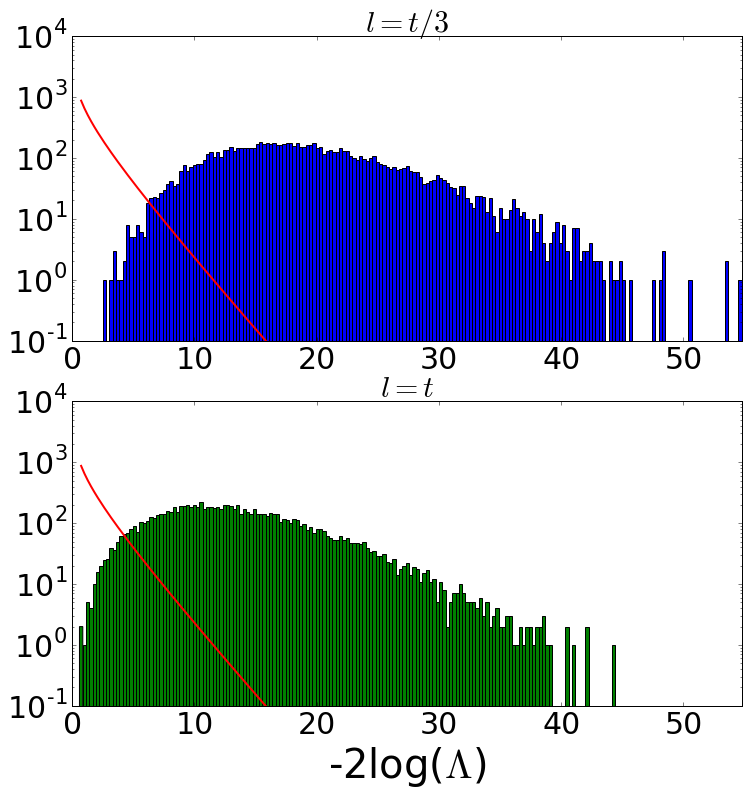

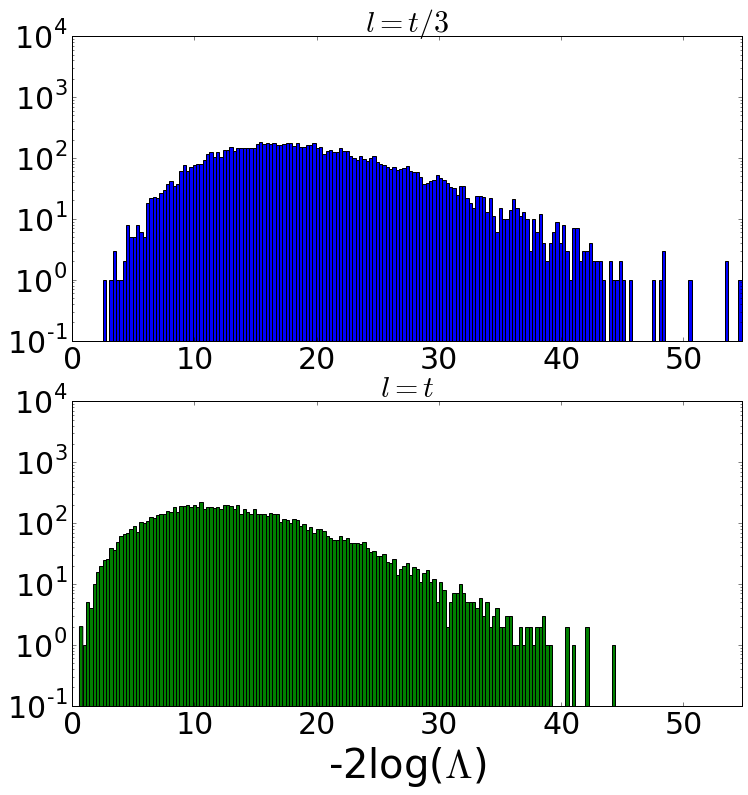

In [30]:
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]

for m in msignals:
    gp_smallL = [s for s in LLlistGP_smallL[m] if not (np.isinf(s) or np.isnan(s))]
    
    gp_neg_frac_smallL = round(100.*sum(i < 0 for i in gp_smallL)/len(gp_smallL),2)
    print "george LL% < 0: ", gp_neg_frac_smallL
    
    gp_smallL = [s for s in gp_smallL if s > 0]
    
    gp_largeL = [s for s in LLlistGP_largeL[m] if not (np.isinf(s) or np.isnan(s))]
    
    gp_neg_frac_largeL = round(100.*sum(i < 0 for i in gp_largeL)/len(gp_largeL),2)
    print "george LL% < 0: ", gp_neg_frac_largeL
    
    gp_largeL = [s for s in gp_largeL if s > 0]
    
    label = r"-2log($\Lambda$) for mass "+str(int(m))
    makePrettyPlots_LLH(gp_smallL, gp_largeL, label, drawchi2=True, xname = r"-2log($\Lambda$)", label1 =r"$l = t/3$", label2 = r"$l = t$")
    
    makePrettyPlots_LLH(gp_smallL, gp_largeL, label, drawchi2=False, xname = r"-2log($\Lambda$)", label1 =r"$l = t/3$", label2 = r"$l = t$")

